# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [1]:
from kan.KAN import KAN
import torch
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons.
model = KAN(width=[2,5,1], seed=42, device=device)

cpu


Create dataset

In [2]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [6]:
import numpy as np
import torch
from scipy.special import j0

# Generate training data
x = np.linspace(-1, 1, 50).reshape(-1, 1)
y = j0(20 * x)

dataset = {
    'train_input': torch.tensor(x, dtype=torch.float32),
    'train_output': torch.tensor(y, dtype=torch.float32)
}

# Create model
model = KAN(width=[1, 1], device='cpu', use_qsp=True)


# Fit model using external optimizer
x_tensor = dataset['train_input']
y_tensor = dataset['train_output']
result = model.fit_qsp_with_alphas(x_tensor, y_tensor, qsp_depth=6, maxiter=10)

# Optional: plot activations
model.plot(folder="./figures_bessel")



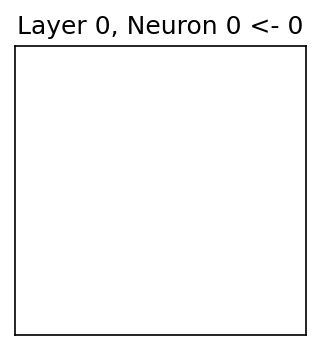

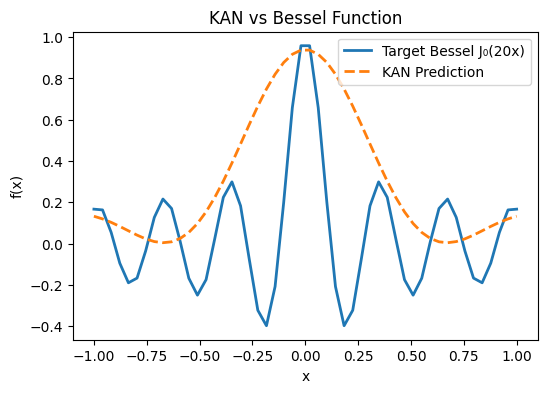

In [7]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN
from IPython.display import Image, display

# Step 1: Generate training data
x = np.linspace(-1, 1, 50).reshape(-1, 1)
y = j0(20 * x)

dataset = {
    'train_input': torch.tensor(x, dtype=torch.float32),
    'train_output': torch.tensor(y, dtype=torch.float32)
}

# Step 2: Create model
model = KAN(width=[1, 1], device='cpu', use_qsp=True)

# Step 3: Fit QSP parameters using external optimizer
result = model.fit_qsp_with_alphas(
    dataset['train_input'],
    dataset['train_output'],
    qsp_depth=6,
    maxiter=10
)

# Step 4: Plot learned activation functions
plot_folder = "./figures_bessel"
model.plot(folder=plot_folder)

# Step 5: Display saved PNG image
saved_plots = sorted(glob.glob(os.path.join(plot_folder, "*.png")))
if saved_plots:
    display(Image(filename=saved_plots[0]))
else:
    print("No plots found.")

# Step 6: Plot prediction vs target
with torch.no_grad():
    y_pred = model(dataset['train_input'], qsp_params=result.x).cpu().numpy()

plt.figure(figsize=(6, 4))
plt.plot(x, y, label='Target Bessel J₀(20x)', linewidth=2)
plt.plot(x, y_pred, '--', label='KAN Prediction', linewidth=2)
plt.legend()
plt.title("KAN vs Bessel Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()



Optimal QSP parameters: [3.96085217 0.66607334 1.9702482  5.59434273 0.97826578 3.74464831
 1.04190456 1.84489429 4.09810236 0.0973251  4.27532191 4.67826372
 0.45528579 4.01307217 2.59941198 3.04857832 5.93147244 0.63034113
 3.7815267  4.09087649 5.59749263]
Optimal alphas: [ 0.82248473  0.87835771  0.83861903  0.48685591  0.93116281  0.77147827
  0.5925883   1.29402353  0.88931139  0.77773557  1.39617269  0.50852914
  1.00761504  0.53506672  0.43372727  0.80751547  0.7442839   0.30817196
 -0.25783886 -0.55428865 -0.49731148 -0.21385212  0.2320952   0.68452203
  0.97201733  0.95877438  0.67240045  0.26197211 -0.1777629  -0.49165507
 -0.55238949 -0.19875102  0.28384648  0.75062618  0.68864009  0.67125109
  0.54602856  0.36299453  0.49693631  0.63268822  0.5605048   1.07575655
  0.98530959  1.02075614  1.03693462  0.30956329  0.75035488  0.87059978
  1.03944956  0.55254699]
Predictions: [ 0.10866573  0.09929474  0.07913146  0.03690488  0.05363729  0.03125902
  0.01530865  0.01978172  0.

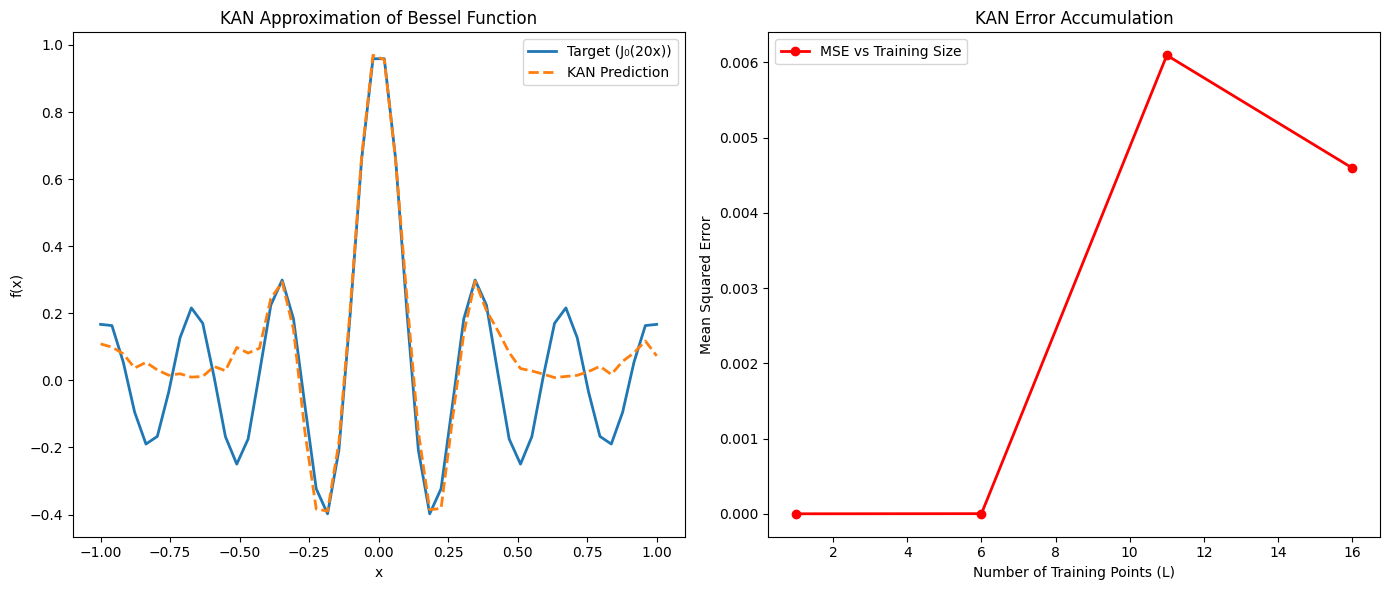

In [2]:
################################################ NEW 1 LAYER ERROR APPROX GRAPHS AND FULL BESSEL FUNCTION EXAMPLE WITH QSP ###############################################
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN  # Adjust to your actual import path

def train_kan_on_dataset(x, y, steps=20):
    model = KAN(qsp_depth=10)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    result = model.fit_qsp_with_alphas(x_tensor, y_tensor, maxiter=steps)

    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]
    preds = model(x_tensor, qsp_params, alphas).detach().numpy()

    print("Optimal QSP parameters:", qsp_params)
    print("Optimal alphas:", alphas)
    print("Predictions:", preds.squeeze())
    print("Target values:", y_tensor.squeeze().numpy())

    return model, preds


# --------------------------------------
# Full input range for function plotting
# --------------------------------------
x_full = np.linspace(-1, 1, 50).reshape(-1, 1)
y_full = j0(20 * x_full)

# Train once on full data for main plot
# model_full, preds_full = train_kan_on_dataset(x_full, y_full, width=[1, 10, 1], steps=10)
model_full, preds_full = train_kan_on_dataset(x_full, y_full, steps=10)

# --------------------------------------
# Error curve for varying training set sizes
# --------------------------------------
errors = []
L_values = np.arange(1, 20, 5)  # from 5 to 50 points

for L in L_values:
    x_small = np.linspace(-1, 1, L).reshape(-1, 1)
    y_small = j0(20 * x_small)
    _, preds_small = train_kan_on_dataset(x_small, y_small, steps=10)
    error = np.mean((preds_small - y_small) ** 2)
    errors.append(error)

# --------------------------------------
# Plot: Function approximation + Error accumulation
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Bessel function approximation
ax1.plot(x_full, y_full, label="Target (J₀(20x))", linewidth=2)
ax1.plot(x_full, preds_full, '--', label="KAN Prediction", linewidth=2)
ax1.set_title("KAN Approximation of Bessel Function")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()

# Right: Error accumulation
ax2.plot(L_values, errors, 'o-r', linewidth=2, label="MSE vs Training Size")
ax2.set_title("KAN Error Accumulation")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Mean Squared Error")
ax2.legend()

plt.tight_layout()
plt.show()


Optimal QSP parameters: [ 4.55054076  4.22180028 -1.62365364 -1.62289303  0.66307225  0.91566915
  0.36742378  5.76436567  5.10263814  0.91982477  1.29688474  3.07177269
  5.72067352  5.50645041  1.07206156  6.14353978  4.02606309  0.55549673
  2.60800185  1.23332784  2.06799322]
Optimal alphas: [ 0.59237359  0.83163938  0.59235334  0.87512905  0.7063701   0.57201125
  1.26216068  0.57232726  1.10209177  0.60464097  0.82895254  0.98995518
  1.19087622  0.7783936   0.60692542  0.46003214  1.07795     1.01987595
  0.82212574  1.27229305  1.34984826  0.76156396  1.28259558  0.57542015
  0.92987552  0.72605968  1.03205509  0.56875058  1.4558277   1.44847705
  1.44732778  0.89689964  0.70142161  1.19527097  1.11761737  0.62563057
  1.19887607  0.99106133  0.76310959  0.76350525  1.10680823  0.69536821
  0.85493237  0.68513816  1.44697148  1.06349552  0.88956654  1.38980517
  0.53401874  1.19152691  1.19698948  0.95231277  1.35679483  0.53397922
  1.34364443  1.1312209   0.54504545  0.943064

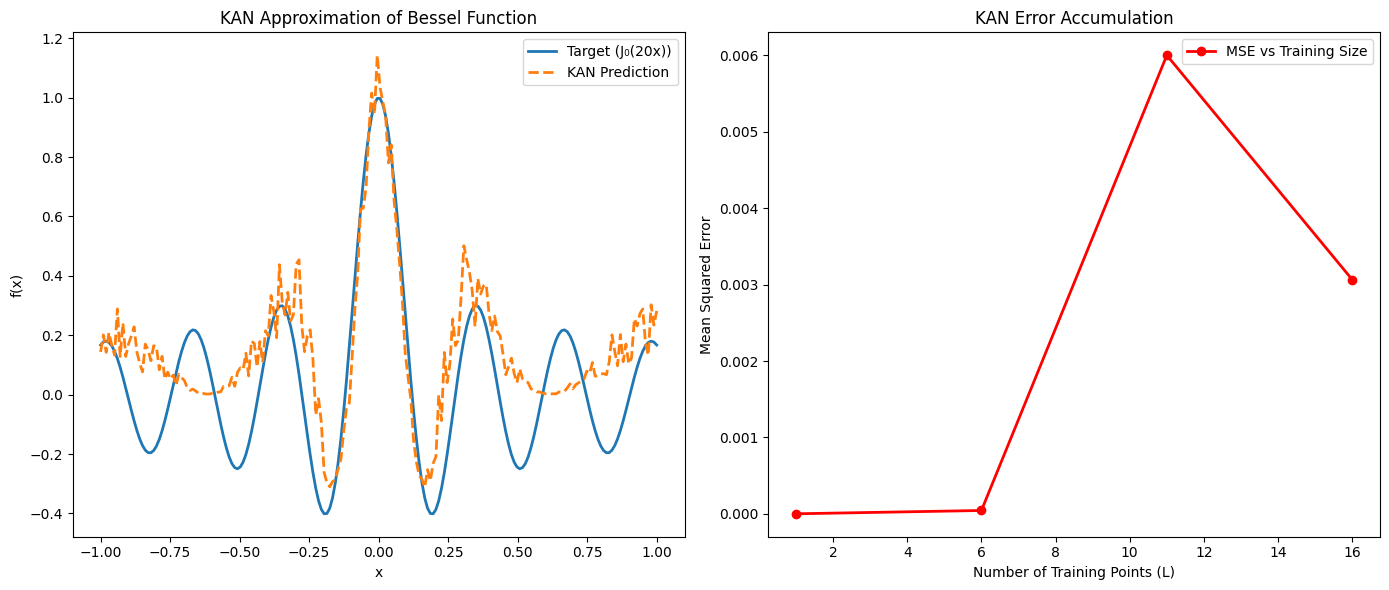

In [3]:
################################################ 200 LINSPACE NEW 1 LAYER ERROR APPROX GRAPHS AND FULL BESSEL FUNCTION EXAMPLE WITH QSP ###############################################
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN  # Adjust to your actual import path

def train_kan_on_dataset(x, y, steps=20):
    model = KAN(qsp_depth=10)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    result = model.fit_qsp_with_alphas(x_tensor, y_tensor, maxiter=steps)

    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]
    preds = model(x_tensor, qsp_params, alphas).detach().numpy()

    print("Optimal QSP parameters:", qsp_params)
    print("Optimal alphas:", alphas)
    print("Predictions:", preds.squeeze())
    print("Target values:", y_tensor.squeeze().numpy())

    return model, preds


# --------------------------------------
# Full input range for function plotting
# --------------------------------------
x_full = np.linspace(-1, 1, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

# Train once on full data for main plot
# model_full, preds_full = train_kan_on_dataset(x_full, y_full, width=[1, 10, 1], steps=10)
model_full, preds_full = train_kan_on_dataset(x_full, y_full, steps=10)

# --------------------------------------
# Error curve for varying training set sizes
# --------------------------------------
errors = []
L_values = np.arange(1, 20, 5)  # from 5 to 50 points

for L in L_values:
    x_small = np.linspace(-1, 1, L).reshape(-1, 1)
    y_small = j0(20 * x_small)
    _, preds_small = train_kan_on_dataset(x_small, y_small, steps=10)
    error = np.mean((preds_small - y_small) ** 2)
    errors.append(error)

# --------------------------------------
# Plot: Function approximation + Error accumulation
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Bessel function approximation
ax1.plot(x_full, y_full, label="Target (J₀(20x))", linewidth=2)
ax1.plot(x_full, preds_full, '--', label="KAN Prediction", linewidth=2)
ax1.set_title("KAN Approximation of Bessel Function")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()

# Right: Error accumulation
ax2.plot(L_values, errors, 'o-r', linewidth=2, label="MSE vs Training Size")
ax2.set_title("KAN Error Accumulation")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Mean Squared Error")
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
################################################ OLD 1 LAYER ERROR APPROX GRAPHS AND FULL BESSEL FUNCTION EXAMPLE WITH QSP ###############################################
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN  # Adjust to your actual import path

def train_kan_on_dataset(x, y, steps=10):
    model = KAN(qsp_depth=10)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    result = model.fit_qsp_with_alphas(x_tensor, y_tensor, maxiter=steps)
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]
    preds = model(x_tensor, qsp_params, alphas).detach().numpy()
    return model, preds



# --------------------------------------
# Full input range for function plotting
# --------------------------------------
x_full = np.linspace(-1, 1, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

# Train once on full data for main plot
model_full, preds_full = train_kan_on_dataset(x_full, y_full, width=[1, 1], steps=10)

# --------------------------------------
# Error curve for varying training set sizes
# --------------------------------------
errors = []
L_values = np.arange(5, 51, 5)  # from 5 to 50 points

for L in L_values:
    x_small = np.linspace(-1, 1, L).reshape(-1, 1)
    y_small = j0(20 * x_small)
    _, preds_small = train_kan_on_dataset(x_small, y_small, width=[1, 1], steps=10)
    error = np.mean((preds_small - y_small) ** 2)
    errors.append(error)

# --------------------------------------
# Plot: Function approximation + Error accumulation
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Bessel function approximation
ax1.plot(x_full, y_full, label="Target (J₀(20x))", linewidth=2)
ax1.plot(x_full, preds_full, '--', label="KAN Prediction", linewidth=2)
ax1.set_title("KAN Approximation of Bessel Function")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()

# Right: Error accumulation
ax2.plot(L_values, errors, 'o-r', linewidth=2, label="MSE vs Training Size")
ax2.set_title("KAN Error Accumulation")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Mean Squared Error")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
################################################ OLD 2 LAYERS ERROR APPROX GRAPHS AND FULL BESSEL FUNCTION EXAMPLE WITH QSP ###############################################
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import j0
from kan.KAN import KAN  # Adjust to your actual import path

def train_kan_on_dataset(x, y, steps=10):
    model = KAN(qsp_depth=10)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    result = model.fit_qsp_with_alphas(x_tensor, y_tensor, maxiter=steps)
    qsp_params = result.x[:model.num_qsp_params]
    alphas = result.x[model.num_qsp_params:]
    preds = model(x_tensor, qsp_params, alphas).detach().numpy()
    return model, preds



# --------------------------------------
# Full input range for function plotting
# --------------------------------------
x_full = np.linspace(-1, 1, 200).reshape(-1, 1)
y_full = j0(20 * x_full)

# Train once on full data for main plot
model_full, preds_full = train_kan_on_dataset(x_full, y_full, width=[1, 10, 10, 1], steps=10)

# --------------------------------------
# Error curve for varying training set sizes
# --------------------------------------
errors = []
L_values = np.arange(5, 51, 5)  # from 5 to 50 points

for L in L_values:
    x_small = np.linspace(-1, 1, L).reshape(-1, 1)
    y_small = j0(20 * x_small)
    _, preds_small = train_kan_on_dataset(x_small, y_small, width=[1, 10, 10, 1], steps=10)
    error = np.mean((preds_small - y_small) ** 2)
    errors.append(error)

# --------------------------------------
# Plot: Function approximation + Error accumulation
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Bessel function approximation
ax1.plot(x_full, y_full, label="Target (J₀(20x))", linewidth=2)
ax1.plot(x_full, preds_full, '--', label="KAN Prediction", linewidth=2)
ax1.set_title("KAN Approximation of Bessel Function")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()

# Right: Error accumulation
ax2.plot(L_values, errors, 'o-r', linewidth=2, label="MSE vs Training Size")
ax2.set_title("KAN Error Accumulation")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Mean Squared Error")
ax2.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Plot KAN at initialization

In [4]:
# train the model
model = KAN(width=[2,5,1], seed=42, device=device)
model(dataset['train_input'])
model.plot()

Train KAN with sparsity regularization

In [6]:
# train the model
model.fit(dataset, opt="LBFGS", steps=5, lamb=0.001)

Plot trained KAN

In [5]:
model.plot()

Prune KAN and replot

In [8]:
model = model.prune()
model.plot()

AttributeError: 'KAN' object has no attribute 'prune'

Continue training and replot

In [7]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.79e-02 | test_loss: 1.72e-02 | reg: 7.66e+00 | : 100%|█| 50/50 [00:06<00:00,  7.21it

saving model version 0.3


In [8]:
model = model.refine(10)

saving model version 0.4


In [9]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.67e-04 | test_loss: 4.73e-04 | reg: 7.66e+00 | : 100%|█| 50/50 [00:06<00:00,  7.37it

saving model version 0.5


Automatically or manually set activation functions to be symbolic

In [10]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999188529035, c=2
fixing (0,1,0) with x^2, r2=0.9999999809840728, c=2
fixing (1,0,0) with exp, r2=0.9999999904907739, c=2
saving model version 0.6


Continue training till machine precision

In [11]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 3.33e-10 | test_loss: 7.20e-11 | reg: 0.00e+00 | : 100%|█| 50/50 [00:02<00:00, 24.56it


saving model version 0.7


Obtain the symbolic formula

In [12]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))